In [7]:
library("rfishbase")
library("tidyverse")

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [91]:
ll <- length_length()
lw <- length_weight()
sp <- speed()

#filter
ll <- ll %>% select(SpecCode, Length1,Length2,a,b) %>% 
    filter((Length1 != "TL") | (Length2 != "TL"))

sp <- sp %>% select(SpecCode, Length, LengthType, Speedms)
lw <- lw %>% select(SpecCode, Type, a, b)

In [99]:
# #convert lengths in speed dataset
ls <- inner_join(sp, ll, by = c("SpecCode")) %>%
    mutate(l = case_when(LengthType == "TL" ~ Length,
                         (LengthType == Length1) & (Length2 == "TL") ~ a + b*Length,
                        .default = NA)) %>%
    filter(!is.na(l)) %>%
    select(-Length1,-Length2, -a, -b) %>%
    distinct()

Warning message in inner_join(sp, ll, by = c("SpecCode")):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 89 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.”


In [143]:
ws <- inner_join(lw, ls, by = "SpecCode") %>%
    filter(Type == "TL") %>%
    unique() %>%
    mutate(w = a + b * l) %>%
    select(-a,-b,-Type,-LengthType) 


Warning message in inner_join(lw, ls, by = "SpecCode"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 264 of `x` matches multiple rows in `y`.
ℹ Row 1 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.”


No summary function supplied, defaulting to `mean_se()`
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 19 rows containing missing values (`geom_segment()`).”


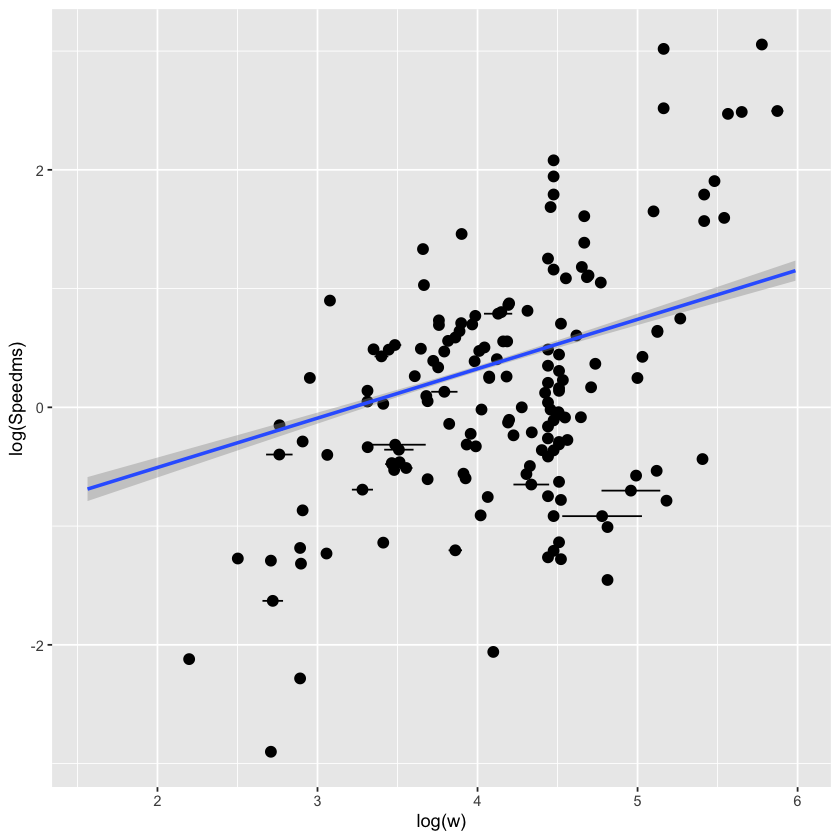

In [151]:
ws %>%
    group_by(SpecCode, Speedms) %>%
    # summarise(w = mean(w)) %>%
    filter(w > 0, Speedms > 0) %>%
    ggplot(aes(log(w), log(Speedms), group = Speedms))+
        stat_summary(orientation = "y")+
        geom_smooth(method = "lm", aes(group = NULL))

In [157]:
mod <- ws %>%
    group_by(SpecCode, Speedms) %>%
    summarise(w = min(w)) %>%
    filter(w > 0, Speedms > 0) %>%
    lm(log(Speedms) ~ log(w), data = .)

`summarise()` has grouped output by 'SpecCode'. You can override using the `.groups` argument.


In [158]:
summary(mod)


Call:
lm(formula = log(Speedms) ~ log(w), data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.21498 -0.60240 -0.06299  0.65893  2.31806 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.23712    0.36227  -6.175 4.40e-09 ***
log(w)       0.57283    0.08793   6.515 7.29e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8808 on 177 degrees of freedom
Multiple R-squared:  0.1934,	Adjusted R-squared:  0.1889 
F-statistic: 42.44 on 1 and 177 DF,  p-value: 7.292e-10
